In [3]:
import pandas as pd
from google.colab import files

uploaded = files.upload()

Saving cars_train_data.csv to cars_train_data (2).csv


In [4]:
df = df[['Class', 'image']]
df.to_csv("filtered_cars.csv", index=False)
df

,Class,image
0,14,00001.jpg
1,3,00002.jpg
2,91,00003.jpg
3,134,00004.jpg
4,106,00005.jpg
...,...,...
8139,78,08140.jpg
8140,196,08141.jpg
8141,163,08142.jpg
8142,112,08143.jpg


Resizing Images with PyTorch  

Q1) Resize Images Using Torchvision

In [6]:
import torch
import torchvision.transforms as transforms
from torchvision.io import read_image
from pathlib import Path
from PIL import Image

# Transformation: Resize, Convert to Tensor, Normalize
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to preprocess an image
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")  # Ensure it's RGB format
    return transform(image)


uploaded = files.upload()

image_path = list(uploaded.keys())[0]

image = Image.open(image_path).convert("RGB")

image_tensor = transform(image)
image_tensor.shape

Saving 00050.jpg to 00050.jpg
torch.Size([3, 224, 224])


Image Embeddings

Q2) Create Class C for Image Embeddings

In [7]:
import torchvision.models as models

class ImageEmbeddingExtractor:
    def __init__(self):
        resnet = models.resnet18(pretrained=True)
        self.model = torch.nn.Sequential(*list(resnet.children())[:-1])  # Remove the last FC layer
        self.model.eval()  # Set to evaluation mode

    def get_embedding(self, image_tensor):
        with torch.no_grad():
            embedding = self.model(image_tensor.unsqueeze(0))  # Add batch dimension
            return embedding.view(-1).numpy()  # Convert to 1D NumPy array

# Initialize model
extractor = ImageEmbeddingExtractor()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 127MB/s]


 Compute Embeddings and Save to CSV

Q3 & Q4) Compute Embeddings and Save to CSV

In [12]:
from pathlib import Path

# 1️⃣ ✅ Uploader les fichiers
uploaded = files.upload()

# 2️⃣ ✅ Récupérer les images uploadées
dataset_path = Path("/content")  # Colab stocke les fichiers ici
image_files = list(dataset_path.glob("*.jpg"))

print(f"📂 {len(image_files)} images trouvées :", image_files)

# 3️⃣ ✅ Process images avec `preprocess_image` et `extractor`
embeddings_list = []
for img_path in image_files:
    img_tensor = preprocess_image(str(img_path))  # Prétraitement de l'image
    embedding = extractor.get_embedding(img_tensor)  # Extraction d'embedding
    embeddings_list.append([img_path.name] + embedding.tolist())

# 4️⃣ ✅ Sauvegarder dans un CSV
df = pd.DataFrame(embeddings_list)
csv_path = "/content/embeddings.csv"
df.to_csv(csv_path, index=False, header=False)

print(f"✅ Embeddings sauvegardés dans {csv_path}")


Saving 00050.jpg to 00050 (1).jpg
Saving 00051.jpg to 00051 (1).jpg
Saving 00052.jpg to 00052.jpg
Saving 00053.jpg to 00053.jpg
Saving 00054.jpg to 00054.jpg
Saving 00055.jpg to 00055.jpg
Saving 00056.jpg to 00056.jpg
Saving 00057.jpg to 00057.jpg
Saving 00058.jpg to 00058.jpg
Saving 00059.jpg to 00059.jpg
Saving 00060.jpg to 00060.jpg
Saving 00061.jpg to 00061.jpg
Saving 00062.jpg to 00062.jpg
Saving 00063.jpg to 00063.jpg
Saving 00064.jpg to 00064.jpg
Saving 00065.jpg to 00065.jpg
Saving 00066.jpg to 00066.jpg
Saving 00067.jpg to 00067.jpg
Saving 00068.jpg to 00068.jpg
Saving 00069.jpg to 00069.jpg
Saving 00070.jpg to 00070.jpg
Saving 00071.jpg to 00071.jpg
Saving 00072.jpg to 00072.jpg
Saving 00073.jpg to 00073.jpg
Saving 00074.jpg to 00074.jpg
Saving 00075.jpg to 00075.jpg
Saving 00076.jpg to 00076.jpg
Saving 00077.jpg to 00077.jpg
Saving 00078.jpg to 00078.jpg
Saving 00079.jpg to 00079.jpg
Saving 00080.jpg to 00080.jpg
Saving 00081.jpg to 00081.jpg
Saving 00082.jpg to 00082.jpg
Sa

 Import Image Embeddings into PySpark

Q5) Create a Spark DataFrame

In [13]:
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, DoubleType

# Initialize Spark
spark = SparkSession.builder.appName("ImageSimilarity").getOrCreate()

# Load CSV into Spark DataFrame
df = spark.read.csv(csv_path, header=False, inferSchema=True)

# Rename columns
columns = ["image"] + [f"dim_{i}" for i in range(512)]
df = df.toDF(*columns)
df.show(5)


+-------------+-------------------+------------------+------------------+-------------------+------------------+-------------------+------------------+--------------------+-------------------+------------------+-------------------+------------------+--------------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------------------+------------------+--------------------+------------------+------------------+------------------+------------------+------------------+--------------------+-------------------+--------------------+--------------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+------------------+-------------------+-------------------+------------------+-------------------+------------------+-------------------+-------------------+-------------------+----------------

Q6) Convert Embeddings to Vector Column

In [14]:
from pyspark.ml.feature import VectorAssembler

# Assemble feature vector
vec_assembler = VectorAssembler(inputCols=[f"dim_{i}" for i in range(512)], outputCol="features")
df_vectorized = vec_assembler.transform(df).select("image", "features")
df_vectorized.show(5)


+-------------+--------------------+
|        image|            features|
+-------------+--------------------+
|    00051.jpg|[0.48388123512268...|
|    00004.jpg|[0.92508077621459...|
|    00022.jpg|[1.37292468547821...|
|    00028.jpg|[1.35347485542297...|
|00050 (1).jpg|[1.12322711944580...|
+-------------+--------------------+
only showing top 5 rows



Image Similarity Search Using PySpark LSH

Q7) Create an LSH Model

In [15]:
from pyspark.ml.feature import BucketedRandomProjectionLSH

# Define LSH model
#we use Euclidean Distance (images, embeddings). to get points that has same bucket
lsh = BucketedRandomProjectionLSH(inputCol="features", outputCol="hashes", bucketLength=10.0, numHashTables=5)
lsh_model = lsh.fit(df_vectorized)


Q8) Generate LSH Hashes

In [32]:
df_hashed = lsh_model.transform(df_vectorized)
df_hashed.select('image','hashes').show(truncate=False)


+-------------+---------------------------------------+
|image        |hashes                                 |
+-------------+---------------------------------------+
|00051.jpg    |[[0.0], [-1.0], [-1.0], [-1.0], [-1.0]]|
|00004.jpg    |[[0.0], [-1.0], [-1.0], [-1.0], [-1.0]]|
|00022.jpg    |[[0.0], [-1.0], [-1.0], [0.0], [-1.0]] |
|00028.jpg    |[[0.0], [-1.0], [-1.0], [-1.0], [-1.0]]|
|00050 (1).jpg|[[0.0], [-1.0], [-1.0], [0.0], [-1.0]] |
|00033.jpg    |[[0.0], [-1.0], [-1.0], [0.0], [-1.0]] |
|00089.jpg    |[[0.0], [-1.0], [-1.0], [0.0], [-1.0]] |
|00045.jpg    |[[0.0], [-1.0], [-1.0], [-1.0], [-1.0]]|
|00059.jpg    |[[0.0], [-1.0], [-1.0], [-1.0], [-1.0]]|
|00003.jpg    |[[0.0], [-1.0], [-1.0], [-1.0], [-1.0]]|
|00023.jpg    |[[0.0], [-1.0], [-1.0], [-1.0], [-1.0]]|
|00057.jpg    |[[0.0], [-1.0], [-1.0], [-1.0], [-1.0]]|
|00006.jpg    |[[0.0], [-1.0], [-1.0], [-1.0], [-1.0]]|
|00031.jpg    |[[0.0], [0.0], [-1.0], [-1.0], [-1.0]] |
|00055.jpg    |[[0.0], [-1.0], [-1.0], [-1.0], [

Q9) Select a Random Image

In [17]:
import random
sample_image = df_hashed.select("image").rdd.takeSample(False, 1)[0][0]
print("Selected Image:", sample_image)


Selected Image: 00011.jpg


Q10) Convert Image to Vector

In [18]:
# Extract the feature vector of the selected image
sample_vector = df_hashed.filter(df_hashed.image == sample_image).select("features").collect()[0][0]


Q11) Perform Approximate Nearest Neighbor Search

In [33]:
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors
from pyspark.sql.types import StructType, StructField, StringType, ArrayType, DoubleType

nearest_neighbors = lsh_model.approxNearestNeighbors(df_hashed, sample_vector, 5)

sample_vector_dense = Vectors.dense(sample_vector)

schema = nearest_neighbors.schema

new_row = spark.createDataFrame([(
    sample_image,
    sample_vector_dense,
    [],
    0.0
)], schema=schema)

print("Schéma de nearest_neighbors:")
nearest_neighbors.printSchema()

print("Schéma de new_row:")
new_row.printSchema()

nearest_neighbors = nearest_neighbors.union(new_row)

nearest_neighbors.select("image", "hashes").show(truncate=False)


Schéma de nearest_neighbors:
root
 |-- image: string (nullable = true)
 |-- features: vector (nullable = true)
 |-- hashes: array (nullable = true)
 |    |-- element: vector (containsNull = true)
 |-- distCol: double (nullable = false)

Schéma de new_row:
root
 |-- image: string (nullable = true)
 |-- features: vector (nullable = true)
 |-- hashes: array (nullable = true)
 |    |-- element: vector (containsNull = true)
 |-- distCol: double (nullable = false)

+---------+---------------------------------------+
|image    |hashes                                 |
+---------+---------------------------------------+
|00011.jpg|[[0.0], [-1.0], [-1.0], [-1.0], [-1.0]]|
|00085.jpg|[[0.0], [-1.0], [-1.0], [-1.0], [-1.0]]|
|00062.jpg|[[0.0], [-1.0], [-1.0], [-1.0], [-1.0]]|
|00082.jpg|[[0.0], [-1.0], [-1.0], [-1.0], [-1.0]]|
|00046.jpg|[[0.0], [-1.0], [-1.0], [-1.0], [-1.0]]|
|00011.jpg|[]                                     |
+---------+---------------------------------------+



Q12) Display Nearest Images

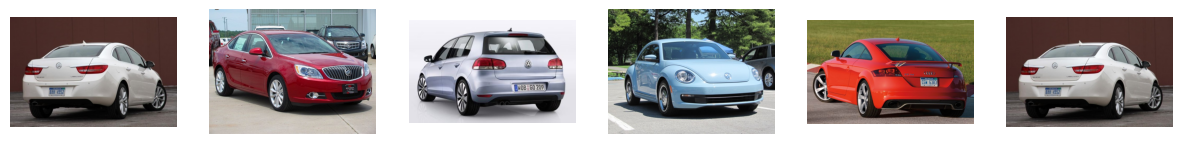

In [31]:
import matplotlib.pyplot as plt

def show_images(image_list, dataset_path):
    fig, axes = plt.subplots(1, len(image_list), figsize=(15, 5))
    for idx, img_name in enumerate(image_list):
        img_path = dataset_path / img_name
        image = Image.open(img_path)
        axes[idx].imshow(image)
        axes[idx].axis("off")
    plt.show()

# Retrieve the image names
nearest_image_names = [row["image"] for row in nearest_neighbors.collect()]

# Display images
show_images(nearest_image_names, dataset_path)
